# Introduction
## Background
This Jupyter Notebook aims to predict the popularity of a song based on its characteristics. This problem matters because knowing what makes songs popular helps musical artists share their work and connect with as many fans as possible. Music is fundamental in uniting communities and enriching culture, and it is by maximizing its popularity that a song reaches its true potential to transform the lives of its listeners.

Results of this model could not only be used to predict how a song is likely to spread worldwide, but they can also be used to analyze cultural trends over time. What makes a song popular now will likely not be what makes it popular in a decade, and especially with an increasingly connected digital world, information flows more quickly than ever. Comparing song popularity indicators over time can be used to indicate how historical events and trends influence what music the general population likes to consume, as well as where this consumption desire is likely to head in the future. Predicting this song popularity will help musicians most effectively connect with a changing global listening population.
## Dataset
The source dataset for this notebook can be accessed [here](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data). The original dataset consists of 114,000 records of songs pulled directly from the Spotify API. Spotify is the most popular music-streaming platform in the world, and it also maintains high-quality information about each of its audio files. Each song contains the following information, not all-inclusive:


*   Identification information such as its title, artist/s, attatched album, and genre
*   Quantitative information such as song duration, beats per minute, and volume distribution
*   Qualitative attributes, such as danceability, energy, and vocalness, translated into a normalized score


For this notebook, the 'popularity' attribute is being separated and used as the label because this is what the model will predict.


### Import necessary libraries and set up the working directory.

In [ ]:
# Installations and imports
%pip install category_encoders

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import category_encoders as ce
from yellowbrick.target import FeatureCorrelation

In [ ]:
# Set up working directory
drive.mount('/content/drive')
%cd /content/drive/MyDrive/School/CS 363M/ML Final Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/School/CS 363M/ML Final Project'
/content/drive/MyDrive/UT/Junior Year/ML Final Project


In [ ]:
# Ryan's Working Directory
drive.mount( '/content/drive')
%cd /content/drive/MyDrive/UT/Junior Year/ML Final Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UT/Junior Year/ML Final Project


# Data Cleaning

### Look at the raw dataset and analyze the given features.

Before we look at our data, it is important to see what our feature set looks like, both to better understand what we may need to do for feature engineering and to note any outliers that might be useful in data exploration

In [ ]:
# View the raw data
df = pd.read_csv('dataset.csv')
print(f'There are {len(df)} records in the dataset.')
df.head()

There are 114000 records in the dataset.


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Looking at just the first five rows, we can already see some features that are notable. First, some features appear to provide little information, such as Unnamed:0 and track_id. Other features, such as album_name and artists won't be very helpful in their own column, so we may need to one-hot encode them or remove them. Finally some numerical features may need to be binned. For example, the exact value of the tempo is less important than whether it is a fast or slow song.

### Remove missing records and duplicate records.

In [ ]:
# Look for missing values
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

It appears there aren't too many missing values, so we can simply drop them without affecting the quality of our dataset too much

In [ ]:
# Remove missing values
df = df.dropna()

One thing we need to keep track of is duplicated songs. There are a couple of songs that have multiple entries in our dataset. We can identify these songs by the artist, track name, and the length of the song. We will keep the record with the highest popularity, since that best represents the height of the song's popularity.

In [ ]:
# For duplicated songs, we will keep the record with the highest popularity value (to represent the best moment of the song)
df = df.sort_values('popularity')
 # features that have to match for records to be considered duplicates
duplicate_features = ['artists', 'track_name', 'duration_ms']
# keep='last' ensures that the highest popularity value records is kept
df = df.drop_duplicates(subset=duplicate_features, keep='last')
df = df.sort_index()

In [ ]:
# Drop songs that have 0 or 1 time signature.
# These seem to be an error in the data and this is just
# a very small fraction of the data so we can afford it
df = df[df['time_signature'] != 0]
df = df[df['time_signature'] != 1]

In [ ]:
# Remove extra index column.
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
# View number of records after removing missing and duplicate values.
print(f'There are {len(df)} records in the dataset.')

There are 82135 records in the dataset.


# Data Exploration

### Ensure clean data.

In [ ]:
# Examine the dataset after cleaning.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82135 entries, 1 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          82135 non-null  object 
 1   artists           82135 non-null  object 
 2   album_name        82135 non-null  object 
 3   track_name        82135 non-null  object 
 4   popularity        82135 non-null  int64  
 5   duration_ms       82135 non-null  int64  
 6   explicit          82135 non-null  bool   
 7   danceability      82135 non-null  float64
 8   energy            82135 non-null  float64
 9   key               82135 non-null  int64  
 10  loudness          82135 non-null  float64
 11  mode              82135 non-null  int64  
 12  speechiness       82135 non-null  float64
 13  acousticness      82135 non-null  float64
 14  instrumentalness  82135 non-null  float64
 15  liveness          82135 non-null  float64
 16  valence           82135 non-null  float64
 1

To begin our data exploration, we should first look at the numerical features. This will tell us if there are any significant outliers or if there are any features we need to feature engineer on to better improve our model's performance

In [ ]:
# Analyze the descriptive statistics for the features and label.
numerical_data = df[df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]]
numerical_data.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,82135.000000,8.213500e+04,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000,82135.000000
mean,35.162769,2.316073e+05,0.561855,0.637341,5.287247,-8.518189,0.633506,0.088219,0.327124,0.180293,0.218681,0.467209,122.476144,3.932160
std,19.512167,1.143806e+05,0.175209,0.256471,3.557698,5.188480,0.481850,0.114166,0.338398,0.328210,0.196745,0.262638,29.658718,0.316085
min,0.000000,1.580000e+04,0.051300,0.000020,0.000000,-46.591000,0.000000,0.022100,0.000000,0.000000,0.009250,0.000000,30.200000,3.000000
25%,21.000000,1.743450e+05,0.449000,0.459000,2.000000,-10.382500,0.000000,0.036100,0.015900,0.000000,0.098400,0.247000,99.901000,4.000000
50%,35.000000,2.155270e+05,0.575000,0.680000,5.000000,-7.233000,1.000000,0.049100,0.188000,0.000079,0.133000,0.454000,122.153000,4.000000
75%,50.000000,2.672020e+05,0.691000,0.857000,8.000000,-5.127000,1.000000,0.086600,0.624000,0.130000,0.282000,0.680000,140.221000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


As show above, it appears most of the features are on a scale from 0 to 1, which is nice since we don't need to normalize the data. However, looking at the numbers doesn't tell us much, so visualizations can help us better understand the distributions of the features.

### Perform univariate analysis of the label and features.

First, we will want to explore the data of the labels. We will first graph the frequency of the popularity of the songs in a histogram. This will tell us whether or not the data is normally distributed or if it is significantly left or right skewed. It can also tell us if there are any outliers.

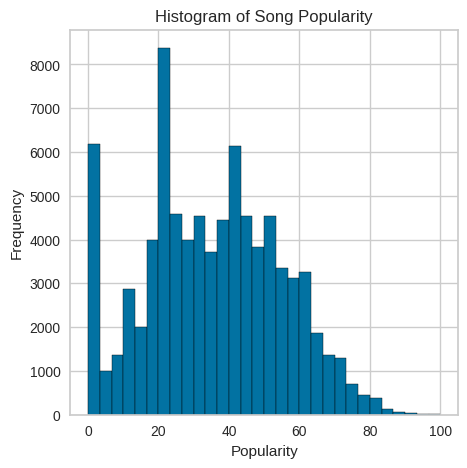

In [ ]:
# Analyze the distribution of the label.
plt.hist(numerical_data['popularity'], bins=30, edgecolor='black')
plt.title('Histogram of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

As shown above, the data is relatively normally distributed with a mean around 38. There are a couple of things that we can note here. First, while we can use regression models to predict the true popularity of a song, we can also categorize a song as either "popular" or "unpopular" based on a threshold. It allears that there are a lot of songs that have 0 popularity, 20 popularity and 40 popularity. Songs past this point could be considered "popular" so a threshold of 50 in categorical modeling may be appropriate in this instance.

Second, there a quite a few spikes at the lower end of this histogram. While this could indicate errors in the data, we believe this actually confirms the validity of the dataset. There are a lot of songs that simply have zero popularity. As of 2024, there are over 100 million songs on Spotify, and only a fraction of them will have any popularity at all. The spikes at 20 and 40 can be explained as songs that are popular within a niche community, but don't enjoy widespread fame across different populations. This may include songs in a certain geographic region or simply a less popular genre.

Looking at the distribution of the numerical features can tell us two things. First, features that are scaled differently may lead to algorithms that weigh features differently. Second, if the distribution is left or right skewed, it may be easier to understand outliers if the data is normalized.

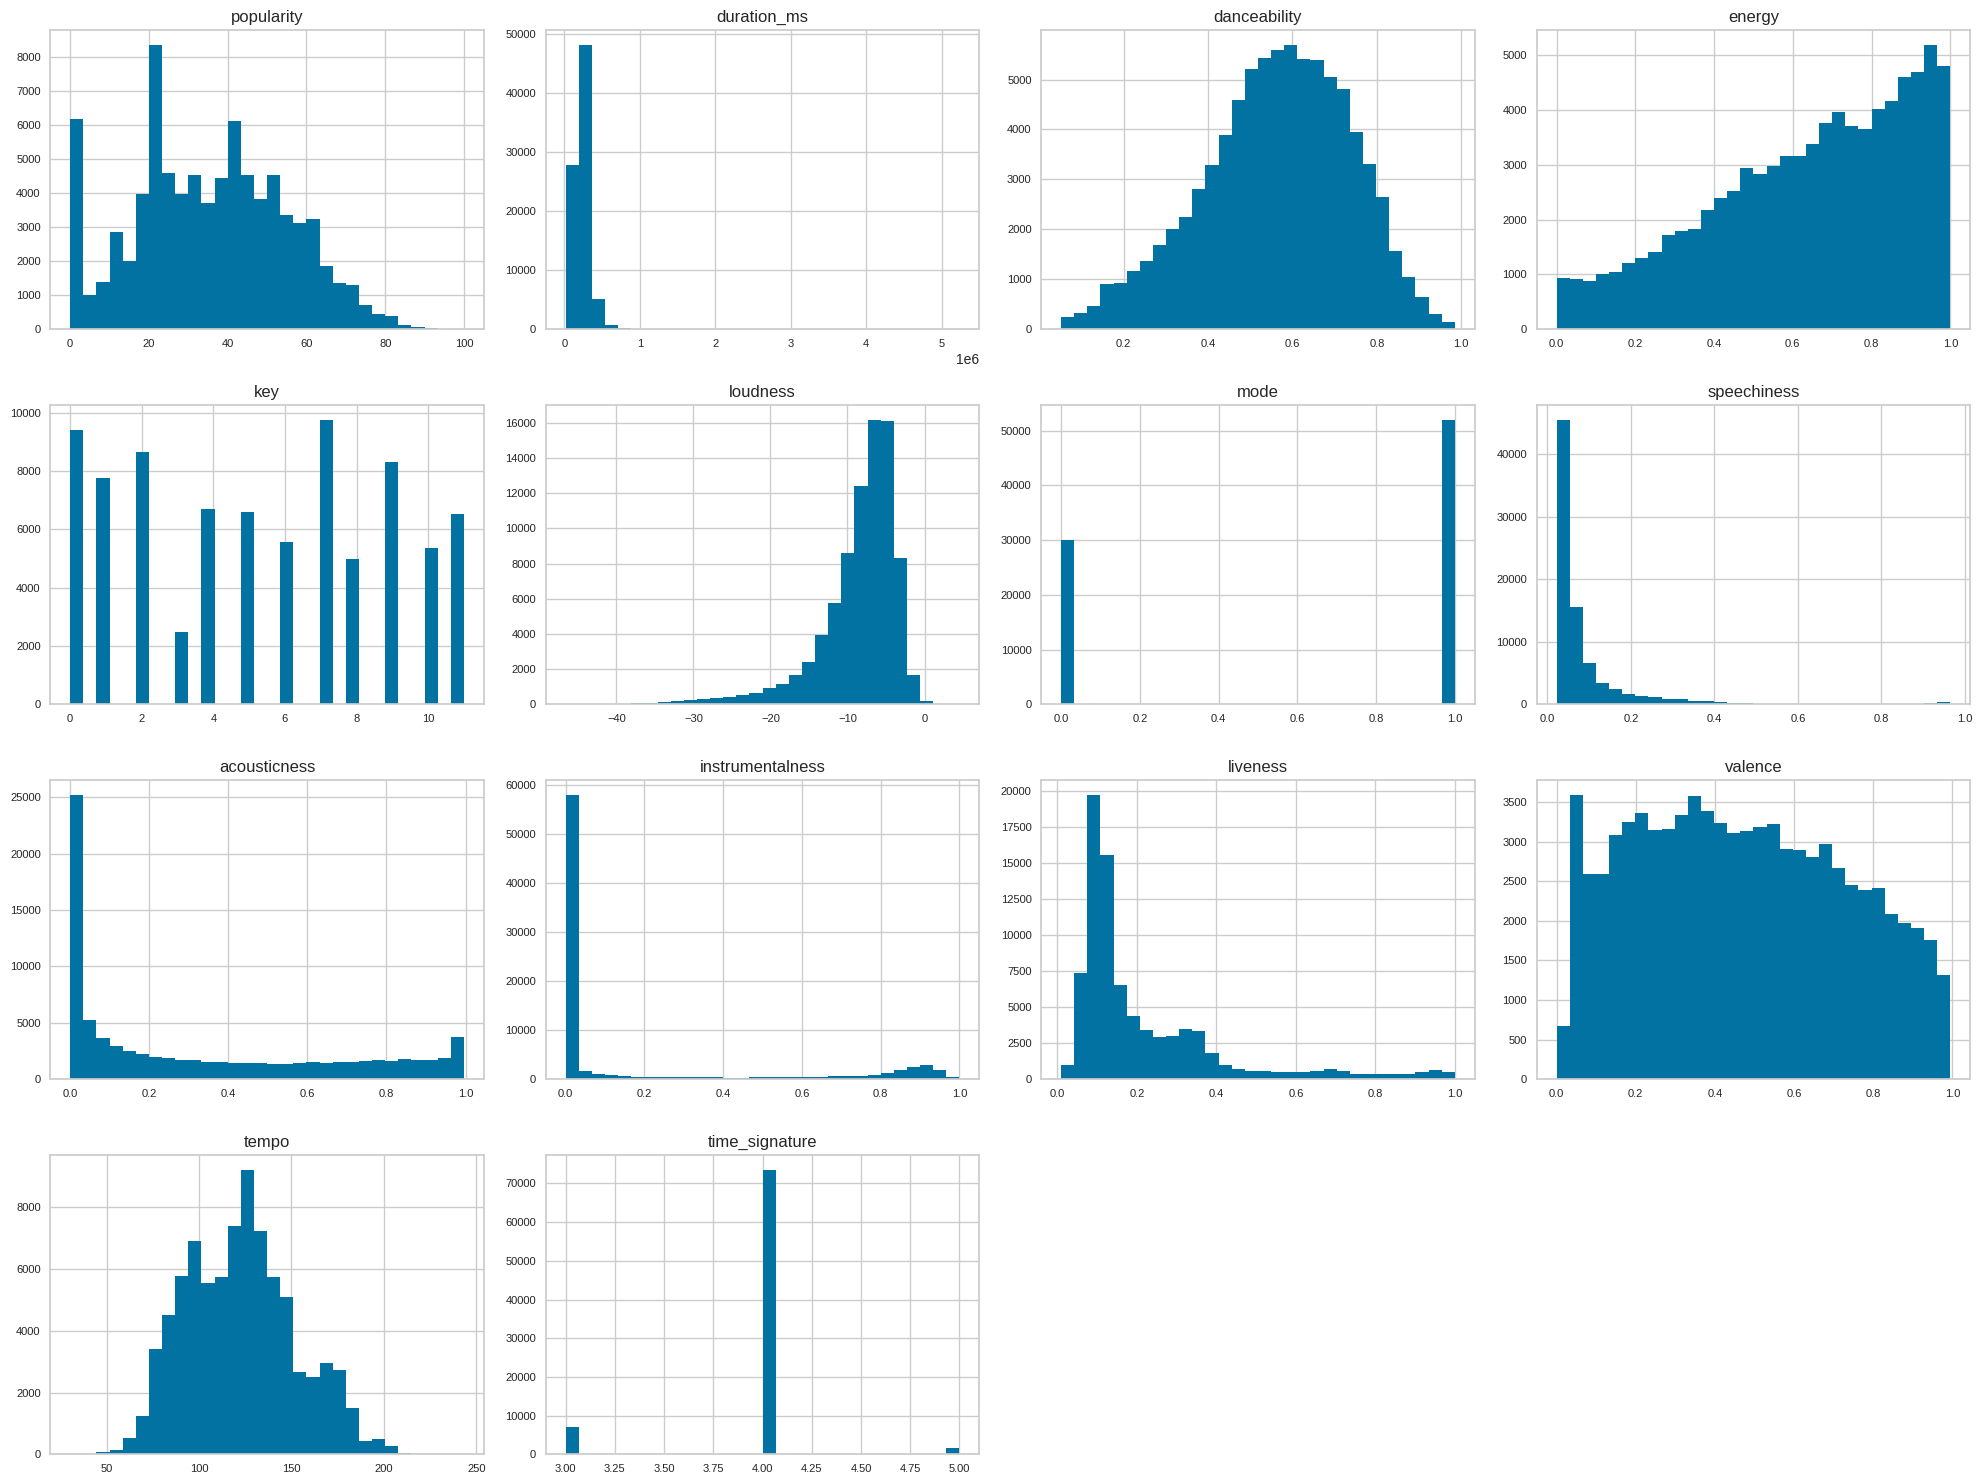

In [ ]:
# Analyze distribution of features.
numerical_data.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

Looking at our data we come to two conclusions

1. Luckily, it seems most of the features in the dataset are scaled from 0 to 1, so distance metrics won't weigh one feature over another (generally)

2. It seems there aren't many normalized features in this dataset outside of danceability and maybe tempo, so normalizing some of the features may improve model performance.

Whether or not we decide to normalize the features, the fact that they are generally scaled similarly from 0 to 1 is helpful since distance metrics won't weigh one feature over another.

### Perform bivariate analysis.

While looking at individual features is certainly interesting, bivariate analysis can help us better understand how features are related to one another. To begin, we can look at the correlation matrix between numerical features within our dataset.

In [ ]:
# Correlation matrix between features.
print(numerical_data.corr())

                  popularity  duration_ms  danceability    energy       key  \
popularity          1.000000    -0.056460      0.093532  0.006798  0.003485   
duration_ms        -0.056460     1.000000     -0.065669  0.059412  0.011381   
danceability        0.093532    -0.065669      1.000000  0.120380  0.031747   
energy              0.006798     0.059412      0.120380  1.000000  0.042430   
key                 0.003485     0.011381      0.031747  0.042430  1.000000   
loudness            0.102049    -0.003363      0.246011  0.761571  0.033864   
mode               -0.006611    -0.036741     -0.060345 -0.070504 -0.144682   
speechiness        -0.065031    -0.062779      0.106114  0.138711  0.013828   
acousticness       -0.043000    -0.108389     -0.162485 -0.732854 -0.041698   
instrumentalness   -0.183774     0.116681     -0.178727 -0.177874 -0.001747   
liveness           -0.033350     0.008810     -0.128263  0.195282 -0.002652   
valence             0.016090    -0.147273      0.484

Interestingly, it appears that there is not a incredibly high correlation between any of the features. Energy and loudness have one of the highest correlations, with a score of 0.7616. This makes sense, since loud songs inherently are more energetic. Similarly danceability and valence have a relatively high correlation value of 0.484. Since valence is how "positive" music is, it makes sense that positive songs are generally easier to dance to.

Of course, since we are trying to predict the popularity of a song, it is important to look at the correlation between popularity and the features of the dataset.

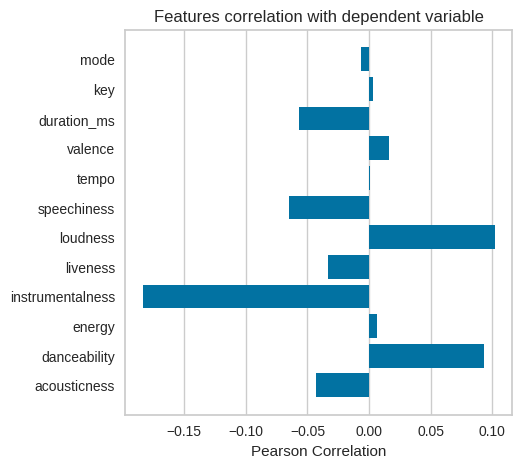

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
# Correlation between each feature variable and label.
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','key','mode']

X, y = numerical_data[feature_names], numerical_data['popularity']

features = np.array(feature_names)

visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(5,5)
visualizer.fit(X, y)
visualizer.show()

There does not seem to be much correlation between any of the individual features and the label, given the ranges of feature correlation.

While all of the values are relatively low, two correlations in particular stand out. Popularity and loudness have a correlation of 0.102, which although low, is much higher than other correlations. Perhaps louder songs have more energy and thus are more popular. Popularity is negatively correlated with instrumentalness with a correlation of -0.183, which may indicate that songs with words are more popular than songs that focus on instrumentals.

Nevertheless, we cannot give much weight to this analysis since the pearson correlation is incredibly low for all features. This may impact how our models will perform.

### Analysis of categorical features.


In [ ]:
categorical_data = df[df.columns[(df.dtypes != 'int64') & (df.dtypes != 'float64')]]
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82135 entries, 1 to 113999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_id     82135 non-null  object
 1   artists      82135 non-null  object
 2   album_name   82135 non-null  object
 3   track_name   82135 non-null  object
 4   explicit     82135 non-null  bool  
 5   track_genre  82135 non-null  object
dtypes: bool(1), object(5)
memory usage: 3.8+ MB


We can see that there are 5 categorical features in addition to the numerical ones. We can use these features for further analysis.

In [ ]:
# Number of unique values for each feature.
print(categorical_data.nunique())

track_id       82135
artists        31217
album_name     45634
track_name     72799
explicit           2
track_genre      114
dtype: int64


Given that many of these categorical features have many unique values, one-hot encoding them would blow up the dimensionality of the dataset. We can see if there are some trends within these features and compared to the label to create new insights.

There are many unique artists, albums, and tracks, whereas the 'explicit' and 'track_genre' features can be analyzed easily.

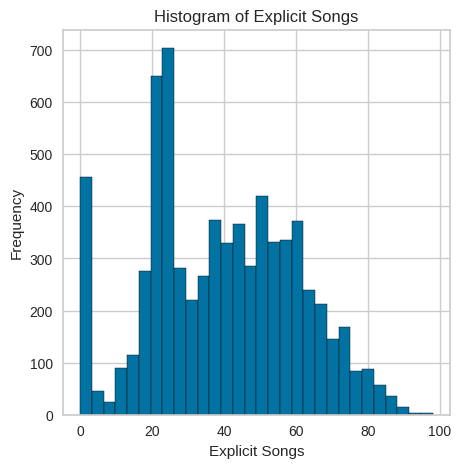

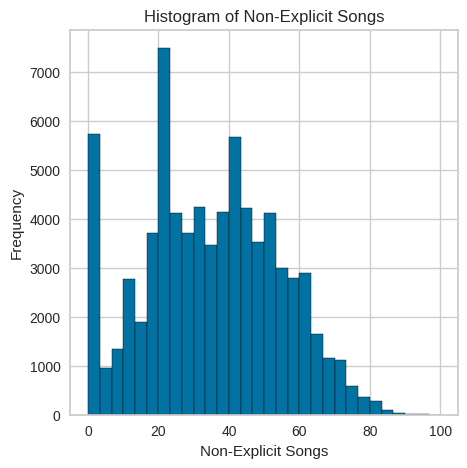

In [ ]:
# Does explicitness have an effect on popularity?
mask_true = df['explicit'] == True
mask_false = df['explicit'] == False

plt.hist(df[mask_true]['popularity'], bins=30, edgecolor='black')
plt.title('Histogram of Explicit Songs')
plt.xlabel('Explicit Songs')
plt.ylabel('Frequency')
plt.show()

plt.hist(df[mask_false]['popularity'], bins=30, edgecolor='black')
plt.title('Histogram of Non-Explicit Songs')
plt.xlabel('Non-Explicit Songs')
plt.ylabel('Frequency')
plt.show()

Since one of the features is binary, we wanted to see if both classes affected the distribution of popularity. However, we can see that a song being explicit or not does not necessarily imply that the popularity will be any different. However, using intuition, albums and artists should have some correlation with popularity.

In [ ]:
# Albums and popularity.
best_albums = df.groupby('album_name')['popularity'].mean()
best_albums = best_albums.sort_values(ascending=False)
print(best_albums[:10])

album_name
Unholy (feat. Kim Petras)                                              100.0
Quevedo: Bzrp Music Sessions, Vol. 52                                   99.0
La Bachata                                                              98.0
Indigo (Extended)                                                       96.0
I Ain’t Worried (Music From The Motion Picture "Top Gun: Maverick")     96.0
RENAISSANCE                                                             93.0
PROVENZA                                                                93.0
Calm Down (with Selena Gomez)                                           92.0
Left and Right (Feat. Jung Kook of BTS)                                 92.0
Super Freaky Girl                                                       92.0
Name: popularity, dtype: float64


The top albums seem to be from all different genres, however they seem to be recent albums. This implies that the release date of the song would have been a significant factor in terms of determining popularity.

In [ ]:
# Artists and popularity.
artist_df = df.copy()
artist_df['artists'] = artist_df['artists'].str.split(';')
artist_df = artist_df.explode('artists')
best_artists = artist_df.groupby('artists')['popularity'].mean()
best_artists = best_artists.sort_values(ascending=False)
print(best_artists[:10])

artists
Quevedo             99.0
Bizarrap            99.0
Harry Styles        92.0
Luar La L           91.0
Beach Weather       90.0
Maldy               90.0
Armani White        89.0
Polimá Westcoast    88.0
Pablo Pesadilla     88.0
Olivia Rodrigo      87.4
Name: popularity, dtype: float64


We see a similar trend with the artists. There seem to be a lot of popularity with Latin-pop artists and hip-hop artists. This indicates that, in addition to artist, genre could also be a large factor.

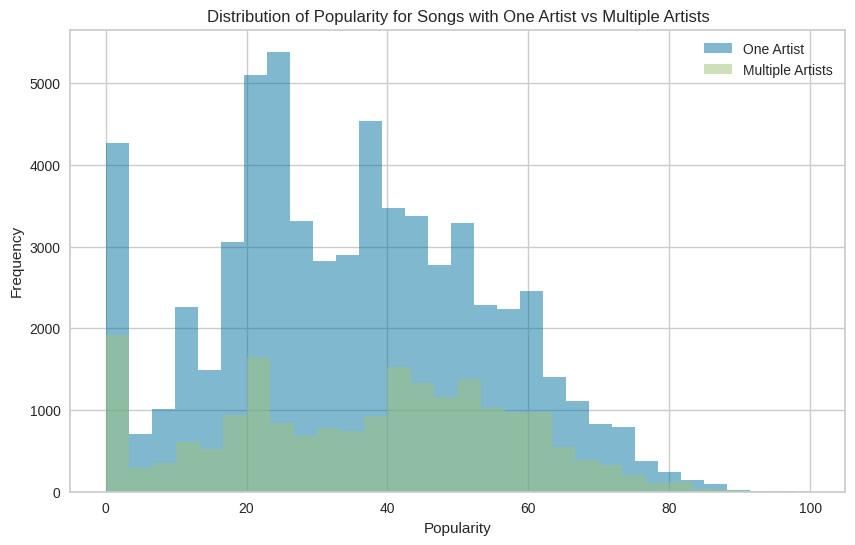

In [ ]:
# Does having multiple artists on a song determine popularity?
df['artist_count'] = df['artists'].apply(lambda x: len(x.split(';')))
df_single_artist = df[df['artist_count'] == 1]
df_multiple_artists = df[df['artist_count'] > 1]
plt.figure(figsize=(10,6))
plt.hist(df_single_artist['popularity'], bins=30, alpha=0.5, label='One Artist')
plt.hist(df_multiple_artists['popularity'], bins=30, alpha=0.5, label='Multiple Artists')
plt.title('Distribution of Popularity for Songs with One Artist vs Multiple Artists')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

One of the hypothesized additional features to add was if a song had multiple artists vs one. Intuitively, it makes sense that if a song has features then it is more likely to be popular. However, comparing the distributions of popularity between both subsets of the data, there does not seem to be a significant difference. For this reason, we did not add that feature as it would only increase the dimensionality unnecessarily.

While artist and album name may very well be useful in determining the popularity of a song, one-hot encoding all possible genres or all possible artists is simply not feasible. Thus, let's look at other categorical features that might impact popularity

Genre is perhaps one of the few discrete features that have a clear correlation with popularity. After all, certain genres are more popular with the general population compared to others. Let's compare the genres based on the average popularity.

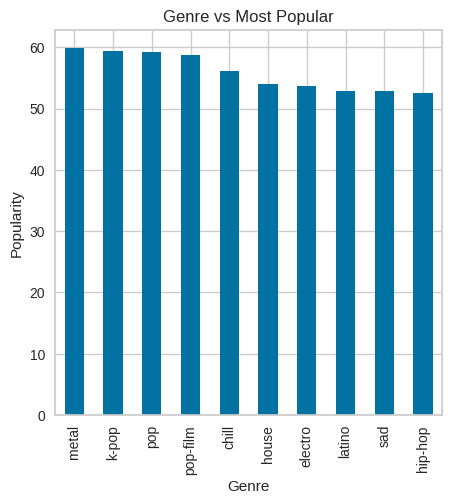

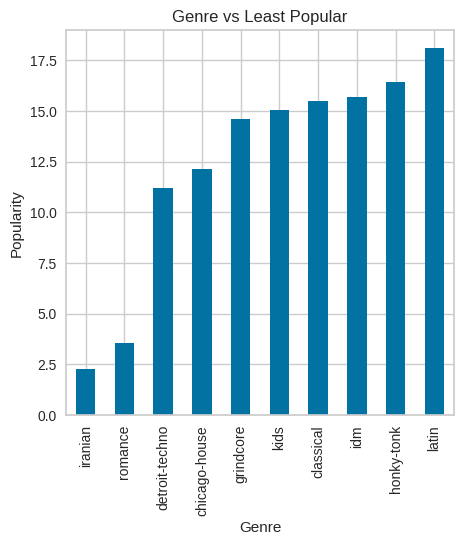

In [ ]:
# Does genre have an effect on popularity?
grouped_genre = df.groupby('track_genre')['popularity']
mean_genre_popularity = grouped_genre.mean()

top_10_genres = mean_genre_popularity.nlargest(10)
top_10_genres.plot(kind='bar', stacked=True)
plt.title('Genre vs Most Popular')
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.show()

bottom_10_genres = mean_genre_popularity.nsmallest(10)
bottom_10_genres.plot(kind='bar', stacked=True)
plt.title('Genre vs Least Popular')
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.show()

As hypothesized and indicated in the other trends for artists and album, certain genres certainly tend to produce songs that are more popular than others. In first place is metal and pop and last place is Iranian. Because of this, it makes sense to one hot encode the genres because this feature will likely help the models.

 However, there is no clear difference between the top genres. Perhaps this is because since there are so many songs in the metal genre, there may also be many metal songs that are low in popularity, bringing down the average. Thus, it may be useful to look at the top 10% songs in each genre to determine the popularity.

 It's interesting to see that metal and kpop, two less popular genres, drop out of the top 10 most popular genres after we look at only the top 10% of tracks.

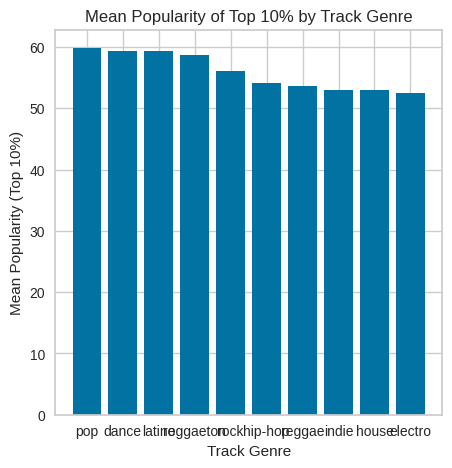

In [ ]:
def top_10_mean(group):
    top_10_percent = np.percentile(group, 90)
    top_10 = group[group >= top_10_percent]
    return top_10.mean()

genres = df.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).head(10)
genres_top_10 = df.groupby('track_genre')['popularity'].apply(top_10_mean).sort_values(ascending=False).head(10)

plt.bar(genres_top_10.index, genres)
plt.title('Mean Popularity of Top 10% by Track Genre')
plt.xlabel('Track Genre')
plt.ylabel('Mean Popularity (Top 10%)')
plt.show()

After this change, pop seems to be the genre that is most correlated to high popularity. This make sense as it is in the name 'pop.'

# Feature Engineering

To begin feature engineering, we note that there are several categorical features that need to be one-hot encoded. We chose to one-hot encode the following features: "mode", "key", "time_signature", and "track_genre"

For "mode", which represents the song's modality, it should not be represented by a numerical 1 or 0. So we converted it to boolean values.

In the original dataset, the "key" feature represents what key the song is in. But to do so, it assigned numbers to certain keys. This needed to be one-hot encoded because these numbers imply a certain order to the keys that isn't entirely representative of how keys in music work.

Similarly, the values for the "time_signature" were represented by numerical values. These would imply an inherit ordering to the time signatures that the model could pick up on. However, this is not the case which is why we chose to one-hot encode this feature.

We believe that one of the most important features is genre, since there are certainly categories of songs that are more popular than others. Thus, while there are a lot of genres that increase the number of features in our dataset, we believe that keeping genre and one-hot encoding it will improve our model's performance.

In [ ]:
# One hot encode the mode (major or minor)
df = pd.get_dummies(data=df, columns=['mode'], drop_first=True)
df = df.rename(columns={'mode_1': 'major_key'})

In [ ]:
# ohe the key
df = pd.get_dummies(data=df, columns=['key'])
# rename the feature names to something more understandable
key_num_to_music_note_dict = {
    'key_0' : 'C',
    'key_1' : 'C#/Db',
    'key_2' : 'D',
    'key_3' : 'D#/Eb',
    'key_4' : 'E',
    'key_5' : 'F',
    'key_6' : 'F#/Gb',
    'key_7' : 'G',
    'key_8' : 'G#/Ab',
    'key_9' : 'A',
    'key_10' : 'A#/Bb',
    'key_11' : 'B',
}
df = df.rename(columns=key_num_to_music_note_dict)

In [ ]:
# ohe the time signature
df = pd.get_dummies(data=df, columns=['time_signature'])

In [ ]:
# ohe the genres
genres = df['track_genre'].unique()
df = pd.get_dummies(data=df, columns=['track_genre'])

After one-hot encoding some of our categorical data, we look to numerical data for binning. There are a couple of features that we believe should not simply be a number. For example, the exact duration of a song is much less important than whether it was a short song or whether it was a longer song. Similarly whether a song had a "fast" or "slow" tempo is more important than the exact numerical value.

In [ ]:
# converts minutes to milliseconds
def min_to_ms(minutes):
  return minutes * 60 * 1000

# takes in a list of tuples of minute values (really the duration_bins_range_in_mins values above) and
# returns a list of tuples with the corresponding millisecond values
def convert_min_tuples_to_ms(min_tuples):
  ret_list = []
  for curr_tuple in min_tuples:
    ret_list.append((min_to_ms(curr_tuple[0]), min_to_ms(curr_tuple[1])))
  return ret_list

# using the tempo binning constants, create the bins used to bin the tempo
def create_tempo_bins():
  return pd.IntervalIndex.from_tuples(list_tempo_bins, closed='left')

# create a dictionary that will map the feature names (which are in milliseconds) after binning and ohe the
# duration to feature names that are in minutes. this is just for easier
# readibility when we are looking at the features
def create_duration_rename_dict(duration_bins):
  duration_label_name = 'duration_ms'
  ms_name_list = []
  mins_name_list = []
  for i in range(len(duration_bins)):
    curr_duration_bin = duration_bins[i]
    curr_mins_tuple = duration_bins_range_in_mins[i]
    ms_name_list.append(duration_label_name + '_' + str(curr_duration_bin) + '')
    if (curr_mins_tuple[1] == max_mins_value):
      mins_name_list.append('>=' + str(curr_mins_tuple[0]))
    else:
      mins_name_list.append(str(curr_mins_tuple[0]) + '-' + str(curr_mins_tuple[1]) + ' mins')
  return dict(zip(ms_name_list, mins_name_list))

In [ ]:
# Some definitions for binning.
max_mins_value = 999
duration_bins_range_in_mins = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 30), (30, max_mins_value)]
tempo_end_value = 300 # end value of the last bin (highest tempo value in dataset is about 220)
list_tempo_bins = [(0, 60), (60, 80), (80, 100), (100, 120), (120, 140), (140, 160), (160, tempo_end_value)]

In [ ]:
# bin the duration (specific ms values dont really matter)
duration_bins = pd.IntervalIndex.from_tuples(convert_min_tuples_to_ms(duration_bins_range_in_mins), closed='left')
df['duration_ms'] = pd.cut(df['duration_ms'], duration_bins)
df = pd.get_dummies(data=df, columns=['duration_ms'])
df = df.rename(columns=create_duration_rename_dict(duration_bins))

In [ ]:
# bin the tempo into groups of group_size (specific tempo values dont really matter)
tempo_bins = create_tempo_bins()
df['tempo'] = pd.cut(df['tempo'], tempo_bins)
df = pd.get_dummies(data=df, columns=['tempo'])

Finally, when looking at our dataset, we noticed that there are a couple of features that would not be of much use. track_id and track_name in particular are two features that won't be useful, the former since it is simply an identification of the track, and the second since track name should be unique to each row anyway.

Two features we struggled to deal with were artists and album_name. Like genre, one approach would be to one-hot encode artists, but given that there are millions of albums and hundreds of thousands of artists around the world, that would not be feasible. Thus, while we could have included another dataset that would allow us to consider artist and albums, we opted to focus on the other features to predict song popularity.

Finally, one feature that we considered was "artist count". This was not originally in the dataset, but we thought that having multiple artists in a song may improve its popularity. However, after trying to run the model with the feature included and without it, we found that it had little impact on model performance. Thus we opted to remove it in our final dataset before modeling.

In [ ]:
columns_to_drop = ['artists', 'track_id', 'album_name', 'track_name', 'artist_count']
df = df.drop(columns=columns_to_drop)

# Modeling


Several modeling techniques will be implemented on the refined dataset to predict song popularity based on a song's characteristics. Various algorithms will be applied to determine which models work effectively and which models do not. Regardless of technique, the label column 'popularity' needs to be separated from the rest of the features:

In [ ]:
label_col = 'popularity'
# Shuffle records
df = df.sample(frac=1)
labels = df.loc[:, df.columns == label_col]
features = df.loc[:, df.columns != label_col]

# Verify that the features is the same except for missing popularity
print(features.head())


       explicit  danceability  energy  loudness  speechiness  acousticness  \
84984     False         0.624   0.730   -12.196       0.1290         0.307   
52542     False         0.527   0.393   -11.336       0.0277         0.827   
20401     False         0.555   0.648    -6.539       0.2960         0.693   
54525     False         0.702   0.615   -13.527       0.0476         0.349   
87691     False         0.785   0.624    -6.644       0.0397         0.201   

       instrumentalness  liveness  valence  major_key  ...  8-10 mins  \
84984          0.000025     0.149    0.519       True  ...      False   
52542          0.000000     0.348    0.624       True  ...      False   
20401          0.000644     0.128    0.641      False  ...      False   
54525          0.266000     0.185    0.161       True  ...      False   
87691          0.000026     0.134    0.899       True  ...      False   

       10-30 mins   >=30  tempo_[0, 60)  tempo_[60, 80)  tempo_[80, 100)  \
84984       Fals

## Regression

Since popularity is an ordinal attribute with integer possibilities ranging from 0 to 100, regression can be an effective way to analyze the song data. There will be three distinct regression evaluators applied to the data. The best versions of these evaluators will then be ensembled to create the optimal regression model for this dataset.

The evaluation metric for these evaluators will be the R^2 score. The R^2 score is a decimal ranging from 0 to 1, and it explains how well the label can be predicted based on the features used in the evaluator. A score of 0 means that the specified features are not at all useful in predicting the label, whereas a score of 1 means that the specified features entirely and exactly predict the label.

### Linear Regression

Fitting a LinearRegression model using all of the dataset's features results in an R^2 score of ~0.39.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Default # folds = 5
linreg = LinearRegression()
R2s = cross_val_score(linreg, features, labels, scoring='r2')
print("Linear Regression Average R2:", R2s.mean())

Linear Regression Average R2: 0.39424838559832465


### Multi-Layer Perceptron Regressor

Fitting a MLPRegressor model using GridSearchCV for optimal parameters results in an optimal hidden layer size of 70, optimal activation function of logistic, and a R^2 score of ~0.42.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Ignore Convergence Warnings because we are only training at 30 epochs
# for simplicity and reasonableness
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

mlp = MLPRegressor(max_iter=30)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('mlp', mlp)])

# Tune to optial hyperparameters
param_grid = {
    'mlp__hidden_layer_sizes': list([40, 50, 60, 70]),
    'mlp__activation': list(['logistic', 'tanh', 'relu']),
}

gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)

# Formatting to fix DataConversionWarning
labels_r = labels.values.ravel()

gridsearch.fit(features, labels_r)
print("Best params:", gridsearch.best_params_)
print("Best score:", gridsearch.best_score_)

nnR2s = cross_val_score(gridsearch.best_estimator_, features, labels_r, cv=5, scoring='r2')
print("Neural Network Average R2:", nnR2s.mean())

Best params: {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': 60}
Best score: 0.4226436914066863
Neural Network Average R2: 0.42231099928342897


### K-Neighbors Regressor

Fitting a KNeighborsRegressor model using GridSearchCV for optimal parameters results in optimal number of PCA components as 60, an optimal k neighbors of 55, and a R^2 score of ~0.41.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
neighbors = KNeighborsRegressor()

# Reduce dimensionality
pca = PCA()
kpipeline = Pipeline([('scaler', scaler), ('pca', pca), ('knn', neighbors)])
#TODO this takes a long time due to the range of values. maybe can shrink this?
kparam_grid = {
    'pca__n_components': list([60, 70, 80, 90]),
    'knn__n_neighbors': list([25, 35, 45, 55])
}
kgridsearcher = GridSearchCV(estimator=kpipeline, param_grid=kparam_grid, cv=5)
kgridsearcher.fit(features, labels)
print("Best params:", kgridsearcher.best_params_)
print("Best score:", kgridsearcher.best_score_)

kR2s = cross_val_score(kgridsearcher.best_estimator_, features, labels, cv=5, scoring='r2')
print("K-Neighbors Average R2:", kR2s.mean())

Best params: {'knn__n_neighbors': 55, 'pca__n_components': 60}
Best score: 0.4060766972438506
K-Neighbors Average R2: 0.4057875609285112


### Ensembling the Three Methods Using VotingRegressor:

In [ ]:
from sklearn.ensemble import VotingRegressor

regensemble = VotingRegressor(estimators=[('linear', linreg), ('mlp', gridsearch.best_estimator_), ('knn', kgridsearcher.best_estimator_)])
regR2s = cross_val_score(regensemble, features, labels, cv=5, scoring='r2')
print("Regression Ensemble Average R2:", regR2s.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

Regression Ensemble Average R2: 0.4143069032593799


Using a VotingRegressor to ensemble the best versions of the linear regressor, neural network regressor, and k-neighbors regressor results in a R^2 score of ~0.42. This means that using a combination of the three base estimators accounts for ~42% of the variation in popularity labels.

This is pretty similar to what we expected from our data exploration. There was little correlation between the features and popularity, so it would be relatively difficult to predict popularity from those features. Nevertheless, we found that MLPRegressor performed marginally better than the other regression models and found that ensembling the three methods also slightly improved performance.

## Classification

Another approach to this problem is to classify songs into groups of popuarity rather than predict an exact metric. Due to the wide range of popularity values, the amount of labels will be reduced through binning the popularity scores, and then evaluate records as belonging in one of several "popularity bins."

Binning thresholds are very important in the effectiveness of these models. For simplicity and readability, popularity is going to be binned in half:

*   0-50 indicates a song which is likely not popular
*   51-100 indicates a song which is likely popular

The evaluation metric is accuracy of classification, meaning that the song was either binned correctly or it was not. The percentage indicates what percentage of songs were binned in the right division.

In [ ]:

# code to bin popularity into popular/not-popular (popular is above 50, not popular is below 50)
pop_binned_df = df
pop_binned_df['popularity'] = pd.cut(pop_binned_df['popularity'], 2, labels=['not popular', 'popular'])
x = pop_binned_df.loc[:, df.columns != 'popularity']
y = pop_binned_df['popularity']
y = pop_binned_df['popularity'].values.ravel()


### Random Forest Classifier

Fitting a RandomForestClassifier using GridSearchCV for optimal parameters results in an average accuracy of ~80.3%.

In [ ]:
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier

RFclf = RandomForestClassifier()

params_grid = {
    'max_depth':[20], #+1 so inclusive
    'min_samples_leaf':[5],
    'max_features':[5, 10]
}


RF_grid_search = skm.GridSearchCV(RFclf, params_grid, cv=5, scoring='accuracy')
RF_grid_search.fit(x, y)
print("Best params:", RF_grid_search.best_params_)
print("Best score:", RF_grid_search.best_score_)


RF_score = cross_val_score(RF_grid_search.best_estimator_, x, y, cv=5)

# print results
print("Random Forest Average Accuracy:", str(RF_score.mean()))

Best params: {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 5}
Best score: 0.8024106653679917
Random Forest Average Accuracy: 0.8023376149022949%


### Gaussian Naive-Bayes Classifier

Fitting a GaussianNB Classifier results in an accuracy of ~66.6%.

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nbaccs = cross_val_score(nb, x, y, cv=5)
print("Gaussian Average Accuracy:", nbaccs.mean())

Gaussian Average Accuracy: 0.6566262859925732


### AdaBoost Classifier

Fitting an AdaBoostClassifier using GridSearchCV for optimal parameters results in an accuracy of ~80.4%.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ABCclf = AdaBoostClassifier()
ada_grid = {
    'n_estimators': [10, 30, 50]
}


ada_grid_search = GridSearchCV(ABCclf, ada_grid, cv=5, scoring='accuracy')
ada_grid_search.fit(x, y)

print("Best params:", ada_grid_search.best_params_)
print("Best score:", ada_grid_search.best_score_)

ada_score = cross_val_score(ada_grid_search.best_estimator_, x, y, cv=5)

# print results
print("Accuracy:", str(ada_score.mean()))


Best params: {'n_estimators': 50}
Best score: 0.8034090217325135
Accuracy: 0.8034090217325135


### Ensembling the Three Methods using VotingClassifier:

In [ ]:
from sklearn.ensemble import VotingClassifier

classensemble = VotingClassifier(estimators=[('rand', RF_grid_search.best_estimator_), ('nb', nb), ('ada', ada_grid_search.best_estimator_)])
ensaccs = cross_val_score(classensemble, x, y, cv=5, scoring='accuracy')
print("Classification Ensemble Average Accuracy:", ensaccs.mean())

Classification Ensemble Average Accuracy: 0.8068667437754916


Using a VotingClassifier to ensemble the best versions of the random forest, naive bayes, and adaboost classifiers results in an accuracy of ~80.7%. This means that using a combination of the three base estimators accurately bins ~80.7% of the songs in terms of popularity.

We found that Gaussian Naive-Bayes Classifier performed the worst out of our three models. Ensembling the models slightly improved performance, though it was on-par with the better performing individual models.

# Analysis and Conclusions


In this project, we performed a variety of models on a feature engineered dataset on Spotify data to predict a song's popularity. We found that our regression models were marginally improved when ensembled, though we still found the results underwhelming. However, there are a couple of explanations for the poor performance.

1. As seen in our data exploration, much of our features are not normally distributed and have little correlation with popularity. Furthermore, many of our features do not necessarily have a linear relationship with popularity, which can also contribute to poor model performance.
2. Some of our features are inherently categorical. Genre, for example, is a categorical feature, and though we one-hot encoded it, regression models may not handle these features well.
3. Regression models are heavily skewed by outliers. Song popularity inherently has a lot of outliers, since there several big big international hits and a lot of songs that are incredibly obscure. These songs can easily lead to poor performance.

After seeing underwhelming performance with regression models, we shifted to looking at classification models. We opted to us a threshold of 50 since it was an easy choice to make. We also looked at the histogram of popularity in our dataset and found that the majority of songs have incredibly low popularity. Thus, we decided that songs with a popularity above 50 could be considered "popular." We found that classification models performed pretty well on our dataset, though ensembling the models we chose only marginally improved performance. However, we found that GNB performed considerably worse than the other models. There are a few explanations for this.

1. GNB has been found to perform much better on categorical data than numerical data. Most of our data is numerical, which means that the model is inherently not suited for the work we want to do.
2. Even if GNB could perform well on numerical data, we did not normalize our features, which could have negatively impacted the model's performance.

While these may not necessarily be the reason why GNB performed poorly on our dataset, they may explain the discrepancy compared to our other models, which performed better. There are a couple explanations why

1. AdaBoost and Random Forest are both better suited for non-linear relationships, which as shown in our data exploration, our data has.
2. Both classifiers are also based on ensembling techniques, which may inherently lead to better performance

Regardless of the data, we can conclude that our classification performed significantly better than our regression models.

# Future Steps

Given more time and resources, there are several things we would have done that we believe would greatly increase the performance of models.

First, if we had a lot more compute resources, we would perform more computationally expensive training. For instance, we could run grid search on way more hyperparameters. This would allow us to find better values for our current models and, consequently, increase their performance. Additionally, we would be able to utilize models that would typically take longer to train. There were several instances where we couldn't use a certain model because of the immense amount of time it took to train on our dataset. Having more computational resources would allow us to access these models and achieve better performance.

Second, we would have researched more into techniques that would allow us to process features whose values can take on an infinite amount of possibilities, namely the album name, song name, and artist name in our dataset. Even though these features most definitely have an impact on the song's popularity, it isn't possible to just one-hot encode these features as it would create too many dimensions and since we didn't learn how to specifically deal with these features in class, we decided to just drop these columns altogether. However, there must exists some methods, such as a natural language processing or encoding technique, that would allow a model to take in these values without blowing up the dimensionality. With more time, we could have looked more into these methods and learned to incorporate them into our algorithms.

Finally, we would have liked to alter the dataset to include more useful information. For example, one useful feature value to have would have been the release date of the song as we believe this would have a strong correlation with a song's current popularity. Furthermore, this data is also accessible on the internet, so, with enough time, we could have learned how to scrap the web and add this valuable information onto our data. This extra information would, in turn, improve the performance of our models.